In [2]:
import sys
import cmath
import math
import os
import h5py
import matplotlib.pyplot as plt   # plots
from matplotlib.ticker import MaxNLocator
import numpy as np
import time
import warnings

from liblibra_core import *
import util.libutil as comn
from libra_py import units
import models
import libra_py.dynamics.tsh.compute as tsh_dynamics
import libra_py.dynamics.tsh.plot as tsh_dynamics_plot
import libra_py.data_savers as data_savers

from recipes import fssh, fssh2, fssh3, gfsh

import libra_py.models.GLVC as GLVC


warnings.filterwarnings('ignore')

colors = {}
colors.update({"11": "#8b1a0e"})  # red       
colors.update({"12": "#FF4500"})  # orangered 
colors.update({"13": "#B22222"})  # firebrick 
colors.update({"14": "#DC143C"})  # crimson   
colors.update({"21": "#5e9c36"})  # green
colors.update({"22": "#006400"})  # darkgreen  
colors.update({"23": "#228B22"})  # forestgreen
colors.update({"24": "#808000"})  # olive      
colors.update({"31": "#8A2BE2"})  # blueviolet
colors.update({"32": "#00008B"})  # darkblue  
colors.update({"41": "#2F4F4F"})  # darkslategray

clrs_index = ["11", "21", "31", "41", "12", "22", "32", "13","23", "14", "24"]


# Population dynamics for FSSH, FSSH2, GFSH

0
1
2


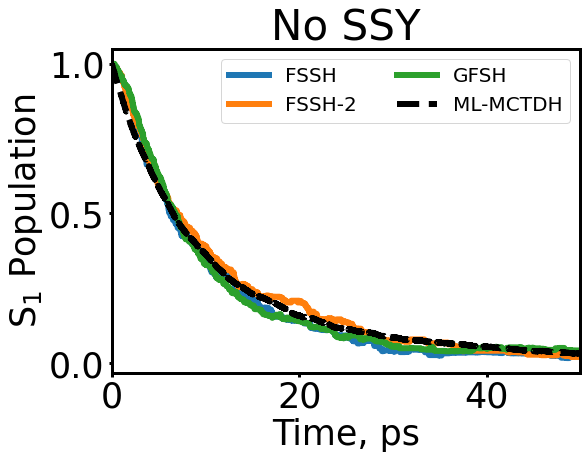

In [3]:
%matplotlib inline
colors = plt.cm.tab10.colors
folders = ['FSSH','FSSH2','GFSH']
labels  = ['FSSH','FSSH-2','GFSH']
plt.rcParams.update({'font.size': 35, 'axes.linewidth': 3, 
                     'xtick.major.width': 3, 'ytick.major.width': 3, 'lines.linewidth': 6.0})
plt.figure(figsize=(3.21*3, 2.41*3))
for k in range(len(folders)):
    print(k)
    sh_pops = []
    for i in range(0,50):
        # The reason is that I excluded that in GFSH and FSSH2 calculations 
        # since they were already in the renamed 
        # 'main->FSSH' folder
        file = f'FSSH/{folders[k]}_ntraj_100_iter_{i}/mem_data.hdf'
        F = h5py.File(file)
        sh_pops.append(np.array(F['sh_pop_adi/data']))
        F.close()
    F = h5py.File(file)
    time_vec = F['time/data'][:]*units.au2fs/1000
    F.close()
    plt.plot(time_vec, np.average(sh_pops, axis=0)[:,1], label=labels[k], color=colors[k])

ml_mctdh = np.loadtxt('reference/ML-MCTDH_n32.dat')
plt.plot(ml_mctdh[:,0]/1000, ml_mctdh[:,1], label='ML-MCTDH', ls='dashed', color='black')
plt.xlim(0,50)
plt.legend(fontsize=20, ncol=2, loc='upper right')
plt.ylabel('S$_1$ Population')
plt.xlabel('Time, ps')
plt.title('No SSY')
plt.tight_layout()
plt.savefig('pop_dyn_fssh_fssh2_gfsh_no_ssy.jpg', dpi=600)

# Check the "decoherence time" for MFSD, SDM, and DISH. Then choose the lowest error for comparison with other methods

## Schwartz 1

MFSD FSSH
MFSD FSSH2
MFSD GFSH
SDM FSSH
SDM FSSH2
SDM GFSH
DISH_REV23 FSSH
DISH_REV23 FSSH2
DISH_REV23 GFSH


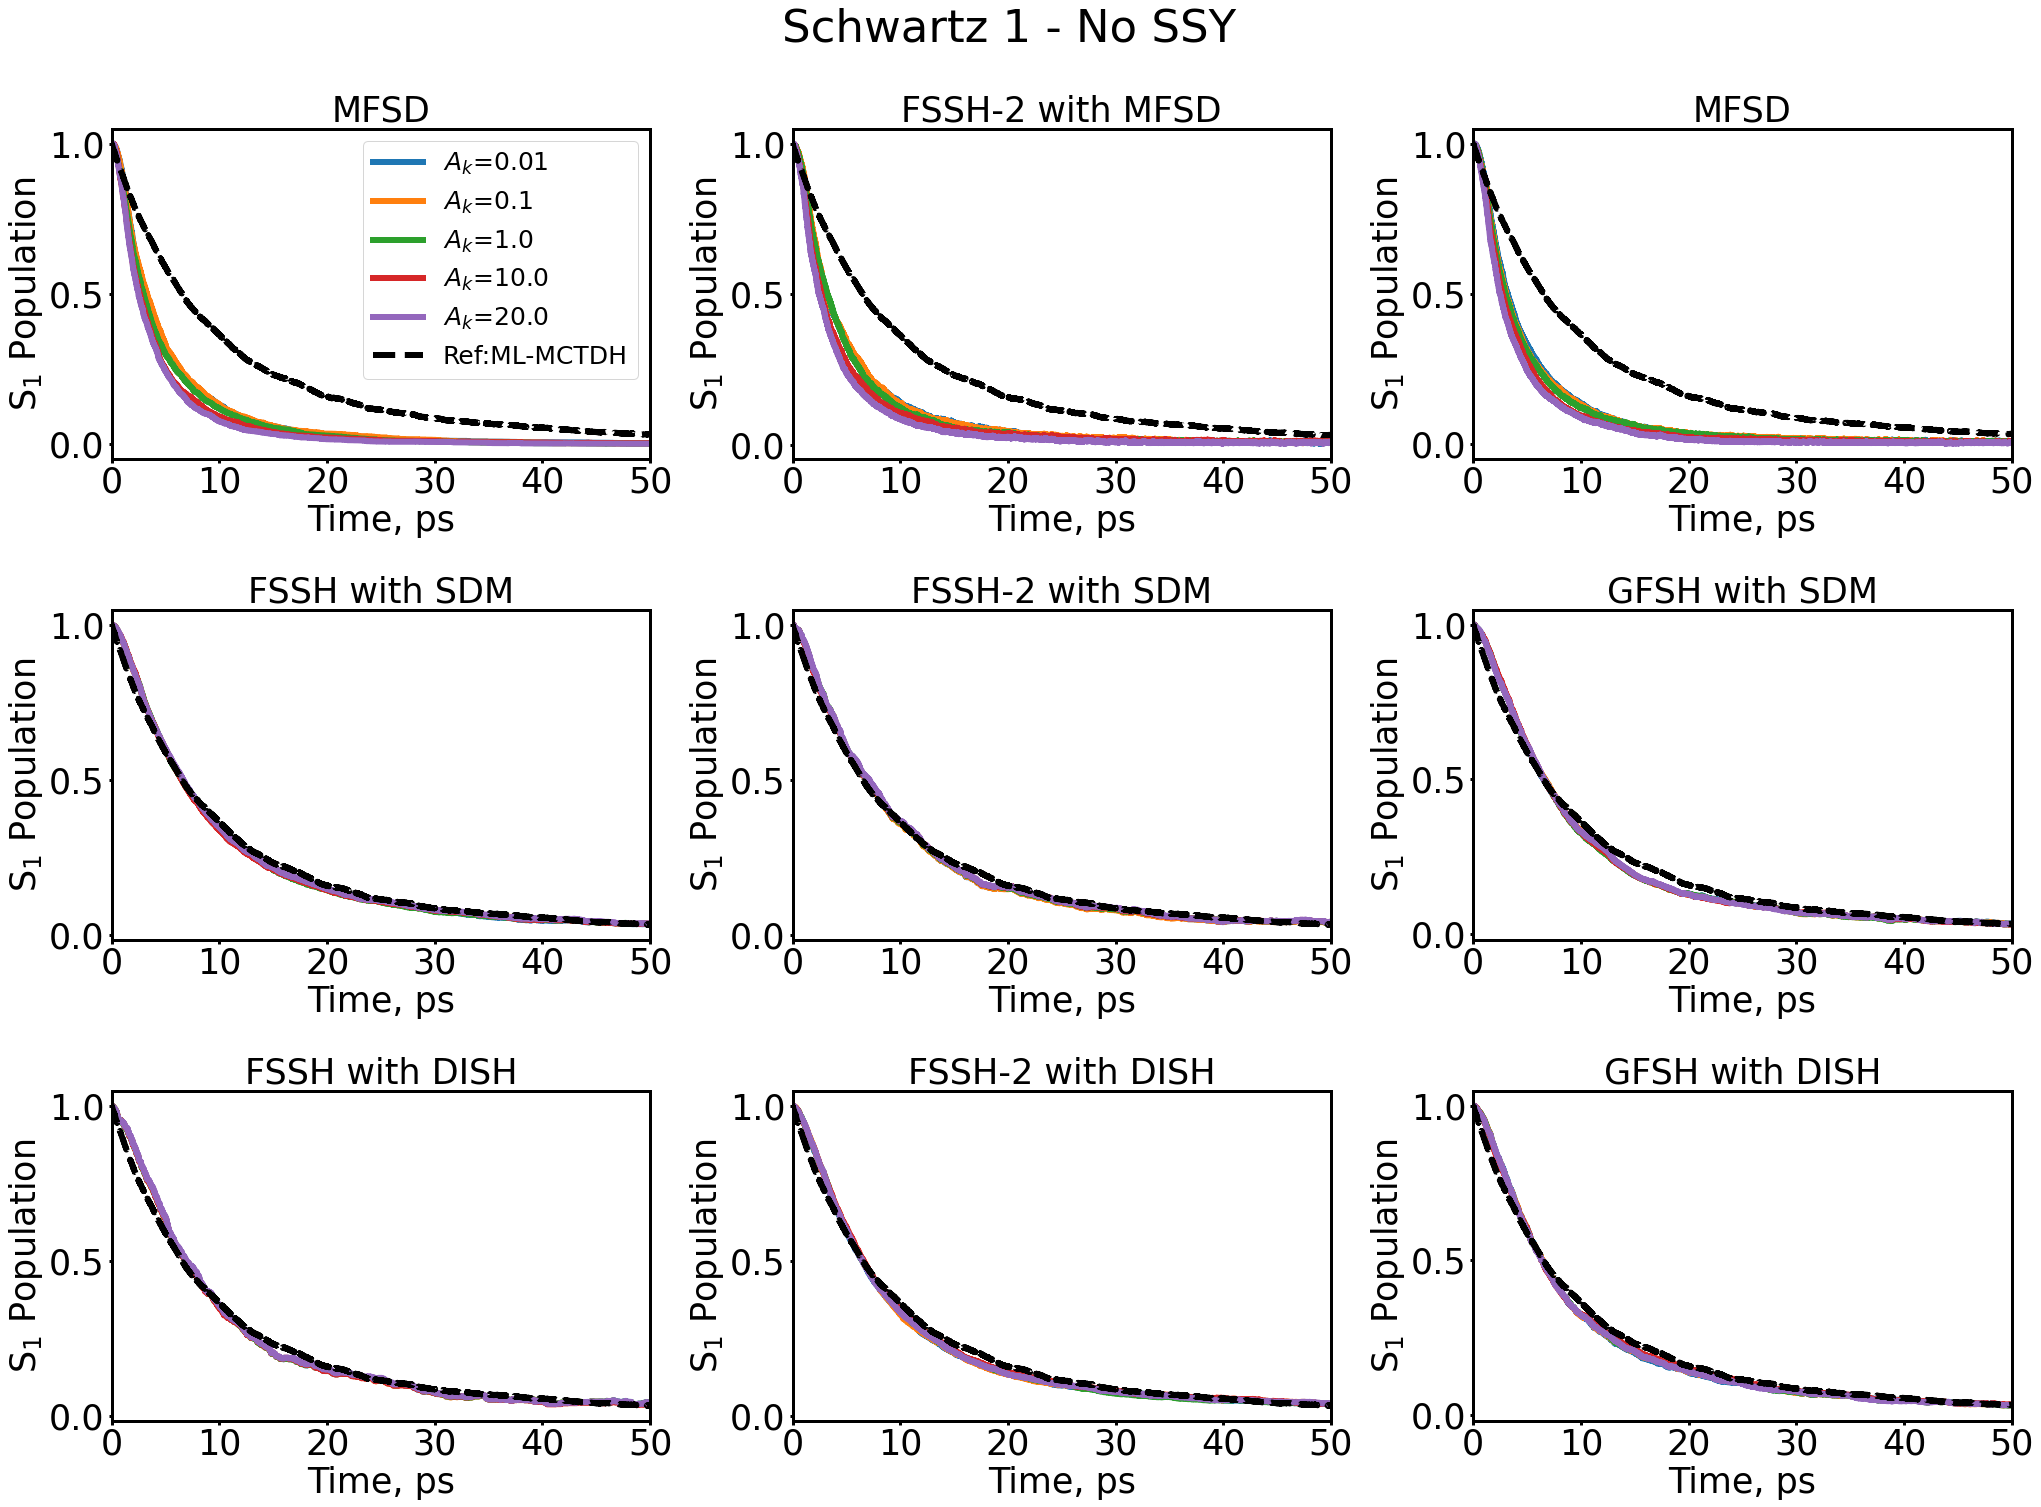

In [18]:
%matplotlib inline
colors = plt.cm.tab10.colors
colors = list(colors)
colors.append('darkblue')
A_vals = [0.01, 0.1, 1.0, 10.0, 20.0]
# 'MFSD_SCHW2_ntraj_100_iter_47_A_0.01'
labels = [f'$A_k$={A_val}' for A_val in A_vals]
plt.rcParams.update({'font.size': 35, 'axes.linewidth': 3, 
                     'xtick.major.width': 3, 'ytick.major.width': 3, 'lines.linewidth': 6.0})


F = h5py.File('FSSH/time.hdf')
time_vec = F['time/data'][:]*units.au2fs/1000
F.close()
plt.figure(figsize=(3.21*3*3, 2.41*3*3))
c = 1
for dec_method in ['MFSD','SDM','DISH_REV23']:
    for method in ['FSSH','FSSH2','GFSH']:
        plt.subplot(3,3,c)
        #plt.figure(figsize=(3.21*3, 2.41*3))
        print(dec_method, method)
        for k in range(len(A_vals)):
            #print(k)
            sh_pops = []
            for i in range(0,50): ###
                #file = f'main/MFSD_ntraj_100_iter_{i}_A_{A_vals[k]}/mem_data.hdf'
                if dec_method=='MFSD':
                    file = f'{method}/{dec_method}_ntraj_100_iter_{i}_A_{A_vals[k]}/mem_data.hdf'
                else:
                    file = f'{method}/{dec_method}_SCHW1_ntraj_100_iter_{i}_A_{A_vals[k]}/mem_data.hdf'
                F = h5py.File(file)
                sh_pops.append(np.array(F['sh_pop_adi/data']))
                F.close()
            F = h5py.File(file)
            F.close()
            #if k==2:
            #    plt.plot(time_vec, np.average(sh_pops, axis=0)[:,1], label=labels[k], color=colors[k], ls='dashed')
            #else:
            plt.plot(time_vec, np.average(sh_pops, axis=0)[:,1], label=labels[k], color=colors[k])

        ml_mctdh = np.loadtxt('reference/ML-MCTDH_n32.dat')
        plt.plot(ml_mctdh[:,0]/1000, ml_mctdh[:,1], label='Ref:ML-MCTDH', ls='dashed', color='black')
        plt.xlim(0,50)
        if c==1:
            plt.legend(fontsize=25, ncol=1, loc='upper right')
        plt.ylabel('S$_1$ Population')
        plt.xlabel('Time, ps')
        name = dec_method.replace('_REV23','')
        if method=='FSSH2':
            plt.title(f'FSSH-2 with {name}', fontsize=35)
        elif dec_method=='MFSD':
            plt.title(f'MFSD', fontsize=35)
        else:
            plt.title(f'{method} with {name}', fontsize=35)
        c += 1
plt.suptitle('Schwartz 1 - No SSY', fontsize=45)
plt.tight_layout()
#plt.savefig(f'{name}_{method}_Schw1.jpg', dpi=600)
plt.savefig(f'Schw1_no_SSY.jpg', dpi=600)

# Schwartz 2

MFSD FSSH
MFSD FSSH2
MFSD GFSH
SDM FSSH
SDM FSSH2
SDM GFSH
DISH_REV23 FSSH
DISH_REV23 FSSH2
DISH_REV23 GFSH


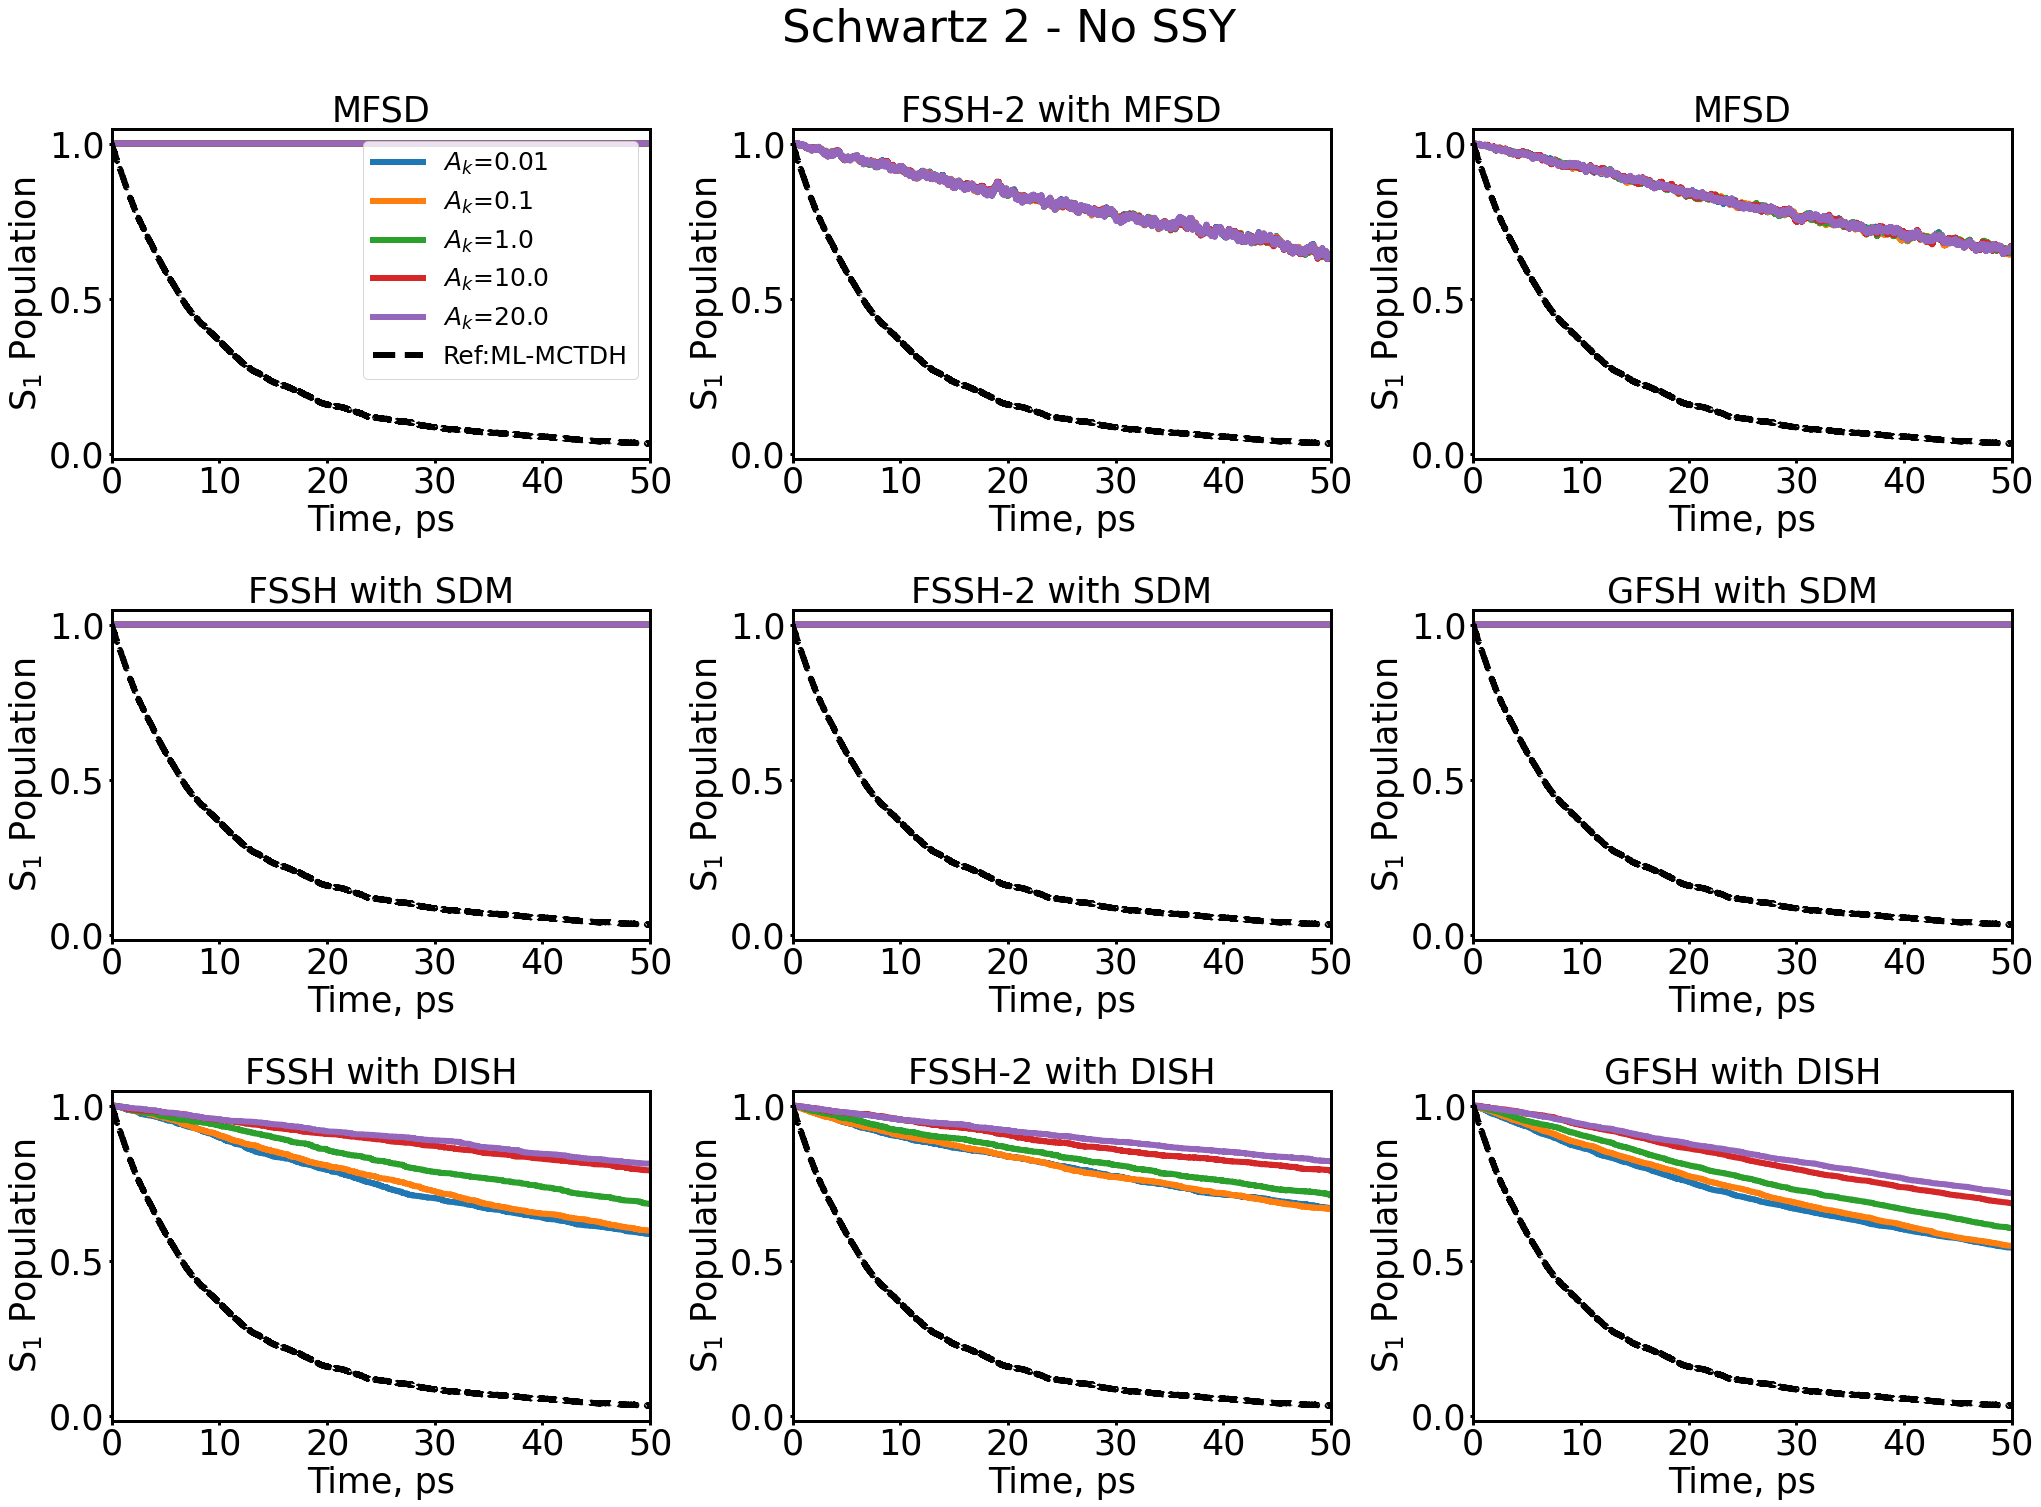

In [19]:
%matplotlib inline
colors = plt.cm.tab10.colors
colors = list(colors)
colors.append('darkblue')
A_vals = [0.01, 0.1, 1.0, 10.0, 20.0]
# 'MFSD_SCHW2_ntraj_100_iter_47_A_0.01'
labels = [f'$A_k$={A_val}' for A_val in A_vals]
plt.rcParams.update({'font.size': 35, 'axes.linewidth': 3, 
                     'xtick.major.width': 3, 'ytick.major.width': 3, 'lines.linewidth': 6.0})


F = h5py.File('FSSH/time.hdf')
time_vec = F['time/data'][:]*units.au2fs/1000
F.close()
c = 1
plt.figure(figsize=(3.21*3*3, 2.41*3*3))
for dec_method in ['MFSD','SDM','DISH_REV23']:
    for method in ['FSSH','FSSH2','GFSH']:
        print(dec_method, method)
        plt.subplot(3,3,c)
        #plt.figure(figsize=(3.21*3, 2.41*3))
        for k in range(len(A_vals)):
            sh_pops = []
            for i in range(0,50): ###
                #file = f'main/MFSD_ntraj_100_iter_{i}_A_{A_vals[k]}/mem_data.hdf'
                file = f'{method}/{dec_method}_SCHW2_ntraj_100_iter_{i}_A_{A_vals[k]}/mem_data.hdf'
                F = h5py.File(file)
                sh_pops.append(np.array(F['sh_pop_adi/data']))
                F.close()
            F = h5py.File(file)
            F.close()
            #if k==2:
            #    plt.plot(time_vec, np.average(sh_pops, axis=0)[:,1], label=labels[k], color=colors[k], ls='dashed')
            #else:
            plt.plot(time_vec, np.average(sh_pops, axis=0)[:,1], label=labels[k], color=colors[k])

        ml_mctdh = np.loadtxt('reference/ML-MCTDH_n32.dat')
        plt.plot(ml_mctdh[:,0]/1000, ml_mctdh[:,1], label='Ref:ML-MCTDH', ls='dashed', color='black')
        plt.xlim(0,50)
        if c==1:
            plt.legend(fontsize=25, ncol=1, loc='upper right')
        plt.ylabel('S$_1$ Population')
        plt.xlabel('Time, ps')
        name = dec_method.replace('_REV23','')
        if method=='FSSH2':
            plt.title(f'FSSH-2 with {name}', fontsize=35)
        elif dec_method=='MFSD':
            plt.title(f'MFSD', fontsize=35)
        else:
            plt.title(f'{method} with {name}', fontsize=35)
        c += 1
plt.suptitle('Schwartz 2 - No SSY', fontsize=45)
plt.tight_layout()
# plt.savefig(f'{name}_{method}_Schw2.jpg', dpi=600)
plt.savefig(f'Schw2_no_SSY.jpg', dpi=600)

## EDC

MFSD FSSH
MFSD FSSH2
MFSD GFSH
SDM FSSH
SDM FSSH2
SDM GFSH
DISH_REV23 FSSH
DISH_REV23 FSSH2
DISH_REV23 GFSH


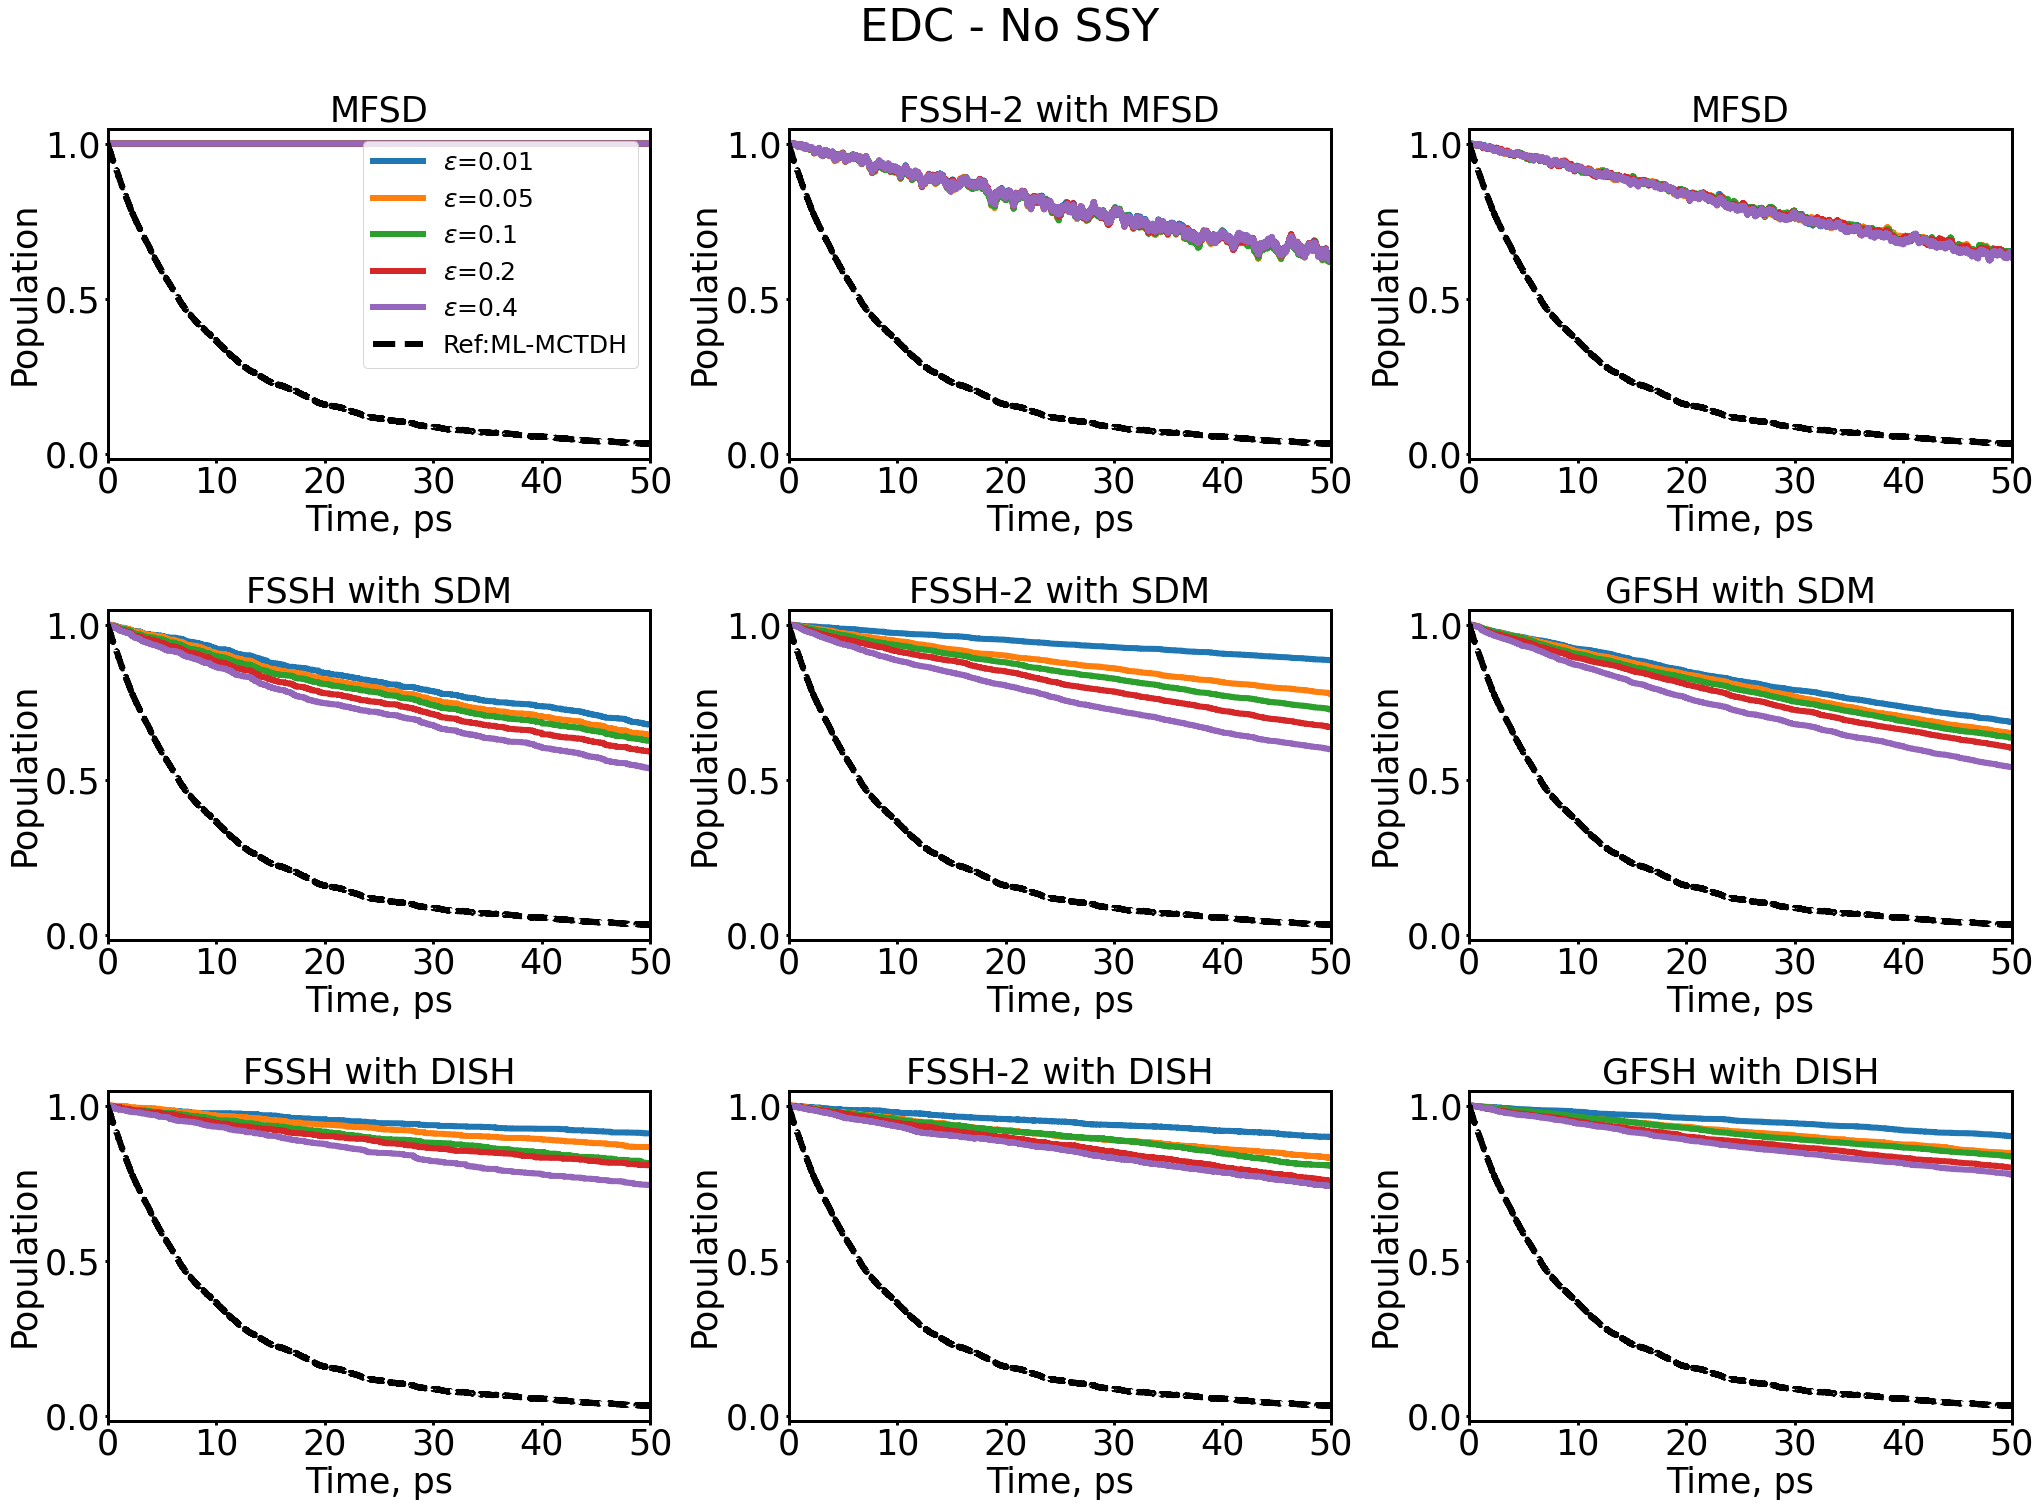

In [20]:
%matplotlib inline
colors = plt.cm.tab10.colors
colors = list(colors)
colors.append('darkblue')
eps_vals = [0.01, 0.05, 0.1, 0.2, 0.4]
# 'MFSD_SCHW2_ntraj_100_iter_47_A_0.01'

labels = [f'$\\epsilon$={eps_val}' for eps_val in eps_vals]
plt.rcParams.update({'font.size': 35, 'axes.linewidth': 3, 
                     'xtick.major.width': 3, 'ytick.major.width': 3, 'lines.linewidth': 6.0})


F = h5py.File('FSSH/time.hdf')
time_vec = F['time/data'][:]*units.au2fs/1000
F.close()
plt.figure(figsize=(3.21*3*3, 2.41*3*3))
c = 1
for dec_method in ['MFSD','SDM','DISH_REV23']:
    for method in ['FSSH','FSSH2','GFSH']:
        print(dec_method, method)
        plt.subplot(3,3,c)
        #plt.figure(figsize=(3.21*3, 2.41*3))
        for k in range(len(eps_vals)):
            #print(dec_method, k)
            sh_pops = []
            for i in range(0,50):
                #file = f'main/MFSD_EDC_ntraj_100_iter_{i}_eps_param_{eps_vals[k]}/mem_data.hdf'
                if dec_method=='SDM':
                    file = f'{method}/{dec_method}_ntraj_100_iter_{i}_eps_param_{eps_vals[k]}/mem_data.hdf'
                else:
                    file = f'{method}/{dec_method}_EDC_ntraj_100_iter_{i}_eps_param_{eps_vals[k]}/mem_data.hdf'
                F = h5py.File(file)
                sh_pops.append(np.array(F['sh_pop_adi/data']))
                F.close()
            F = h5py.File(file)
            F.close()
            plt.plot(time_vec, np.average(sh_pops, axis=0)[:,1], label=labels[k], color=colors[k])
        ml_mctdh = np.loadtxt('reference/ML-MCTDH_n32.dat')
        plt.plot(ml_mctdh[:,0]/1000, ml_mctdh[:,1], label='Ref:ML-MCTDH', ls='dashed', color='black') 
        plt.xlim(0,50) 
        if c==1:
            plt.legend(fontsize=25, ncol=1, loc='upper right')
        plt.ylabel('Population')
        plt.xlabel('Time, ps')
        name = dec_method.replace('_REV23','')
        if method=='FSSH2':
            plt.title(f'FSSH-2 with {name}', fontsize=35)
        elif dec_method=='MFSD':
            plt.title(f'MFSD', fontsize=35)
        else:
            plt.title(f'{method} with {name}', fontsize=35)
        c += 1
plt.suptitle('EDC - No SSY', fontsize=45)
plt.tight_layout()
# plt.savefig(f'{name}_{method}_EDC.jpg', dpi=600)
plt.savefig(f'EDC_no_SSY.jpg', dpi=600)

# Error measurement for decoherence times

## For decoherence times for Schwartz 1 and 2

In [23]:
nsteps = 500000
all_errors_A = []
folders = ['FSSH','FSSH2','BCSH','GFSH','SHXF','ID-A','MFSD','MFSD_EDC','MFSD_SCHW2',
          'SDM','SDM_SCHW1','SDM_SCHW2','DISH_REV23_EDC','DISH_REV23_SCHW1','DISH_REV23_SCHW2']
labels  = ['FSSH','FSSH2','BCSH','GFSH','SHXF','ID-A','MFSD, Schwartz 1','MFSD, EDC','MFSD, Schwartz 2',
          'SDM, EDC', 'SDM, Schwartz 1','SDM, Schwartz 2','DISH, EDC','DISH, Schwartz 1','DISH, Schwartz 2']
A_vals = [0.01, 0.1, 1.0, 10.0, 20.0]
eps_vals = [0.01, 0.05, 0.1, 0.2, 0.4]
for method in ['FSSH','FSSH2','GFSH']:
    print(method)
    all_errors_ = []
    for A_val in A_vals:
        #print(A_val)
        all_errors = []
        for k in [6,8,10,11,13,14]:
            errors = []
            sh_pops = []
            for i in range(0,50):
                file = f'{method}/{folders[k]}_ntraj_100_iter_{i}_A_{A_val}/mem_data.hdf'
                F = h5py.File(file)
                sh_pop = np.array(F['sh_pop_adi/data'])
                F.close()
                #print(sh_pop.shape)
                #error1 = np.average(np.abs(mctdh[0:420000,1]-sh_pop[0:2100000:5,1]))
                error2 = np.average(np.abs(ml_mctdh[0:420000,1]-sh_pop[0:2100000:5,1]))
                errors.append(error2)
            all_errors.append(errors)
        all_errors_.append(all_errors)
    all_errors_A.append(all_errors_)
F = h5py.File('FSSH/time.hdf')
time_vec = F['time/data'][:]*units.au2fs/1000
F.close()

# print(mctdh.shape, ml_mctdh.shape)
all_errors_A = np.array(all_errors_A)
print(all_errors_A.shape)
# print(all_errors)

FSSH
FSSH2
GFSH
(3, 5, 6, 50)


In [24]:
print([folders[i] for i in [6,8,10,11,13,14]])

['MFSD', 'MFSD_SCHW2', 'SDM_SCHW1', 'SDM_SCHW2', 'DISH_REV23_SCHW1', 'DISH_REV23_SCHW2']


## For decoherence times for EDC

In [25]:
nsteps = 500000
all_errors_eps = []
folders = ['FSSH','FSSH2','BCSH','GFSH','SHXF','ID-A','MFSD','MFSD_EDC','MFSD_SCHW2',
          'SDM','SDM_SCHW1','SDM_SCHW2','DISH_REV23_EDC','DISH_REV23_SCHW1','DISH_REV23_SCHW2']
labels  = ['FSSH','FSSH2','BCSH','GFSH','SHXF','ID-A','MFSD, Schwartz 1','MFSD, EDC','MFSD, Schwartz 2',
          'SDM, EDC', 'SDM, Schwartz 1','SDM, Schwartz 2','DISH, EDC','DISH, Schwartz 1','DISH, Schwartz 2']
A_vals = [0.01, 0.1, 1.0, 10.0, 20.0]
eps_vals = [0.01, 0.05, 0.1, 0.2, 0.4]
for method in ['FSSH','FSSH2','GFSH']:
    print(method)
    all_errors_ = []
    for eps_val in eps_vals:
        #print(eps_val)
        all_errors = []
        for k in [7,9,12]:
            errors = []
            sh_pops = []
            for i in range(0,50):
                file = f'{method}/{folders[k]}_ntraj_100_iter_{i}_eps_param_{eps_val}/mem_data.hdf'
                F = h5py.File(file)
                sh_pop = np.array(F['sh_pop_adi/data'])
                F.close()
                #print(sh_pop.shape)
                #error1 = np.average(np.abs(mctdh[0:420000,1]-sh_pop[0:2100000:5,1]))
                error2 = np.average(np.abs(ml_mctdh[0:420000,1]-sh_pop[0:2100000:5,1]))
                errors.append(error2)
            all_errors.append(errors)
        all_errors_.append(all_errors)
    all_errors_eps.append(all_errors_)
F = h5py.File('FSSH/time.hdf')
time_vec = F['time/data'][:]*units.au2fs/1000
F.close()

# print(mctdh.shape, ml_mctdh.shape)
all_errors_eps = np.array(all_errors_eps)
print(all_errors_eps.shape)
# print(all_errors)

FSSH
FSSH2
GFSH
(3, 5, 3, 50)


In [26]:
print([folders[i] for i in [7,9,12]])

['MFSD_EDC', 'SDM', 'DISH_REV23_EDC']


## For {Method, BCSH, SHXF, ID-A}

In [27]:
nsteps = 500000
#all_errors_ = []
folders = ['FSSH','FSSH2','BCSH','GFSH','SHXF','ID-A','MFSD','MFSD_EDC','MFSD_SCHW2',
          'SDM','SDM_SCHW1','SDM_SCHW2','DISH_REV23_EDC','DISH_REV23_SCHW1','DISH_REV23_SCHW2']
labels  = ['FSSH','FSSH2','BCSH','GFSH','SHXF','ID-A','MFSD, Schwartz 1','MFSD, EDC','MFSD, Schwartz 2',
          'SDM, EDC', 'SDM, Schwartz 1','SDM, Schwartz 2','DISH, EDC','DISH, Schwartz 1','DISH, Schwartz 2']
A_vals = [0.01, 0.1, 1.0, 10.0, 20.0]
eps_vals = [0.01, 0.05, 0.1, 0.2, 0.4]
all_errors = []
for method in ['FSSH','FSSH2','GFSH']:
    print(method)
    all_errors_ = []
    # Only for the method itself, plus with BCSH, SHXF, and ID-A
    for k in [0,2,4,5]:
        #print(k)
        errors = []
        sh_pops = []
        for i in range(0,50):
            if k==0:
                file = f'{method}/{method}_ntraj_100_iter_{i}/mem_data.hdf'
            else:
                file = f'{method}/{folders[k]}_ntraj_100_iter_{i}/mem_data.hdf'
            F = h5py.File(file)
            sh_pop = np.array(F['sh_pop_adi/data'])
            F.close()
            #print(sh_pop.shape)
            #error1 = np.average(np.abs(mctdh[0:420000,1]-sh_pop[0:2100000:5,1]))
            error2 = np.average(np.abs(ml_mctdh[0:420000,1]-sh_pop[0:2100000:5,1]))
            errors.append(error2)
        all_errors_.append(errors)
    all_errors.append(all_errors_)
#all_errors_eps.append(all_errors)
F = h5py.File('FSSH/time.hdf')
time_vec = F['time/data'][:]*units.au2fs/1000
F.close()

# print(mctdh.shape, ml_mctdh.shape)
all_errors = np.array(all_errors)
print(all_errors.shape)
# print(all_errors)

FSSH
FSSH2
GFSH
(3, 4, 50)


In [28]:
print([folders[i] for i in [0,1,2,3,4,5]])

['FSSH', 'FSSH2', 'BCSH', 'GFSH', 'SHXF', 'ID-A']


# Done by error measurement!!!

In [29]:
# variables are
print(all_errors_A.shape)
print(all_errors_eps.shape)
print(all_errors.shape)

(3, 5, 6, 50)
(3, 5, 3, 50)
(3, 4, 50)


In [30]:
all_errors_A[0].shape

(5, 6, 50)

FSSH
FSSH2
GFSH


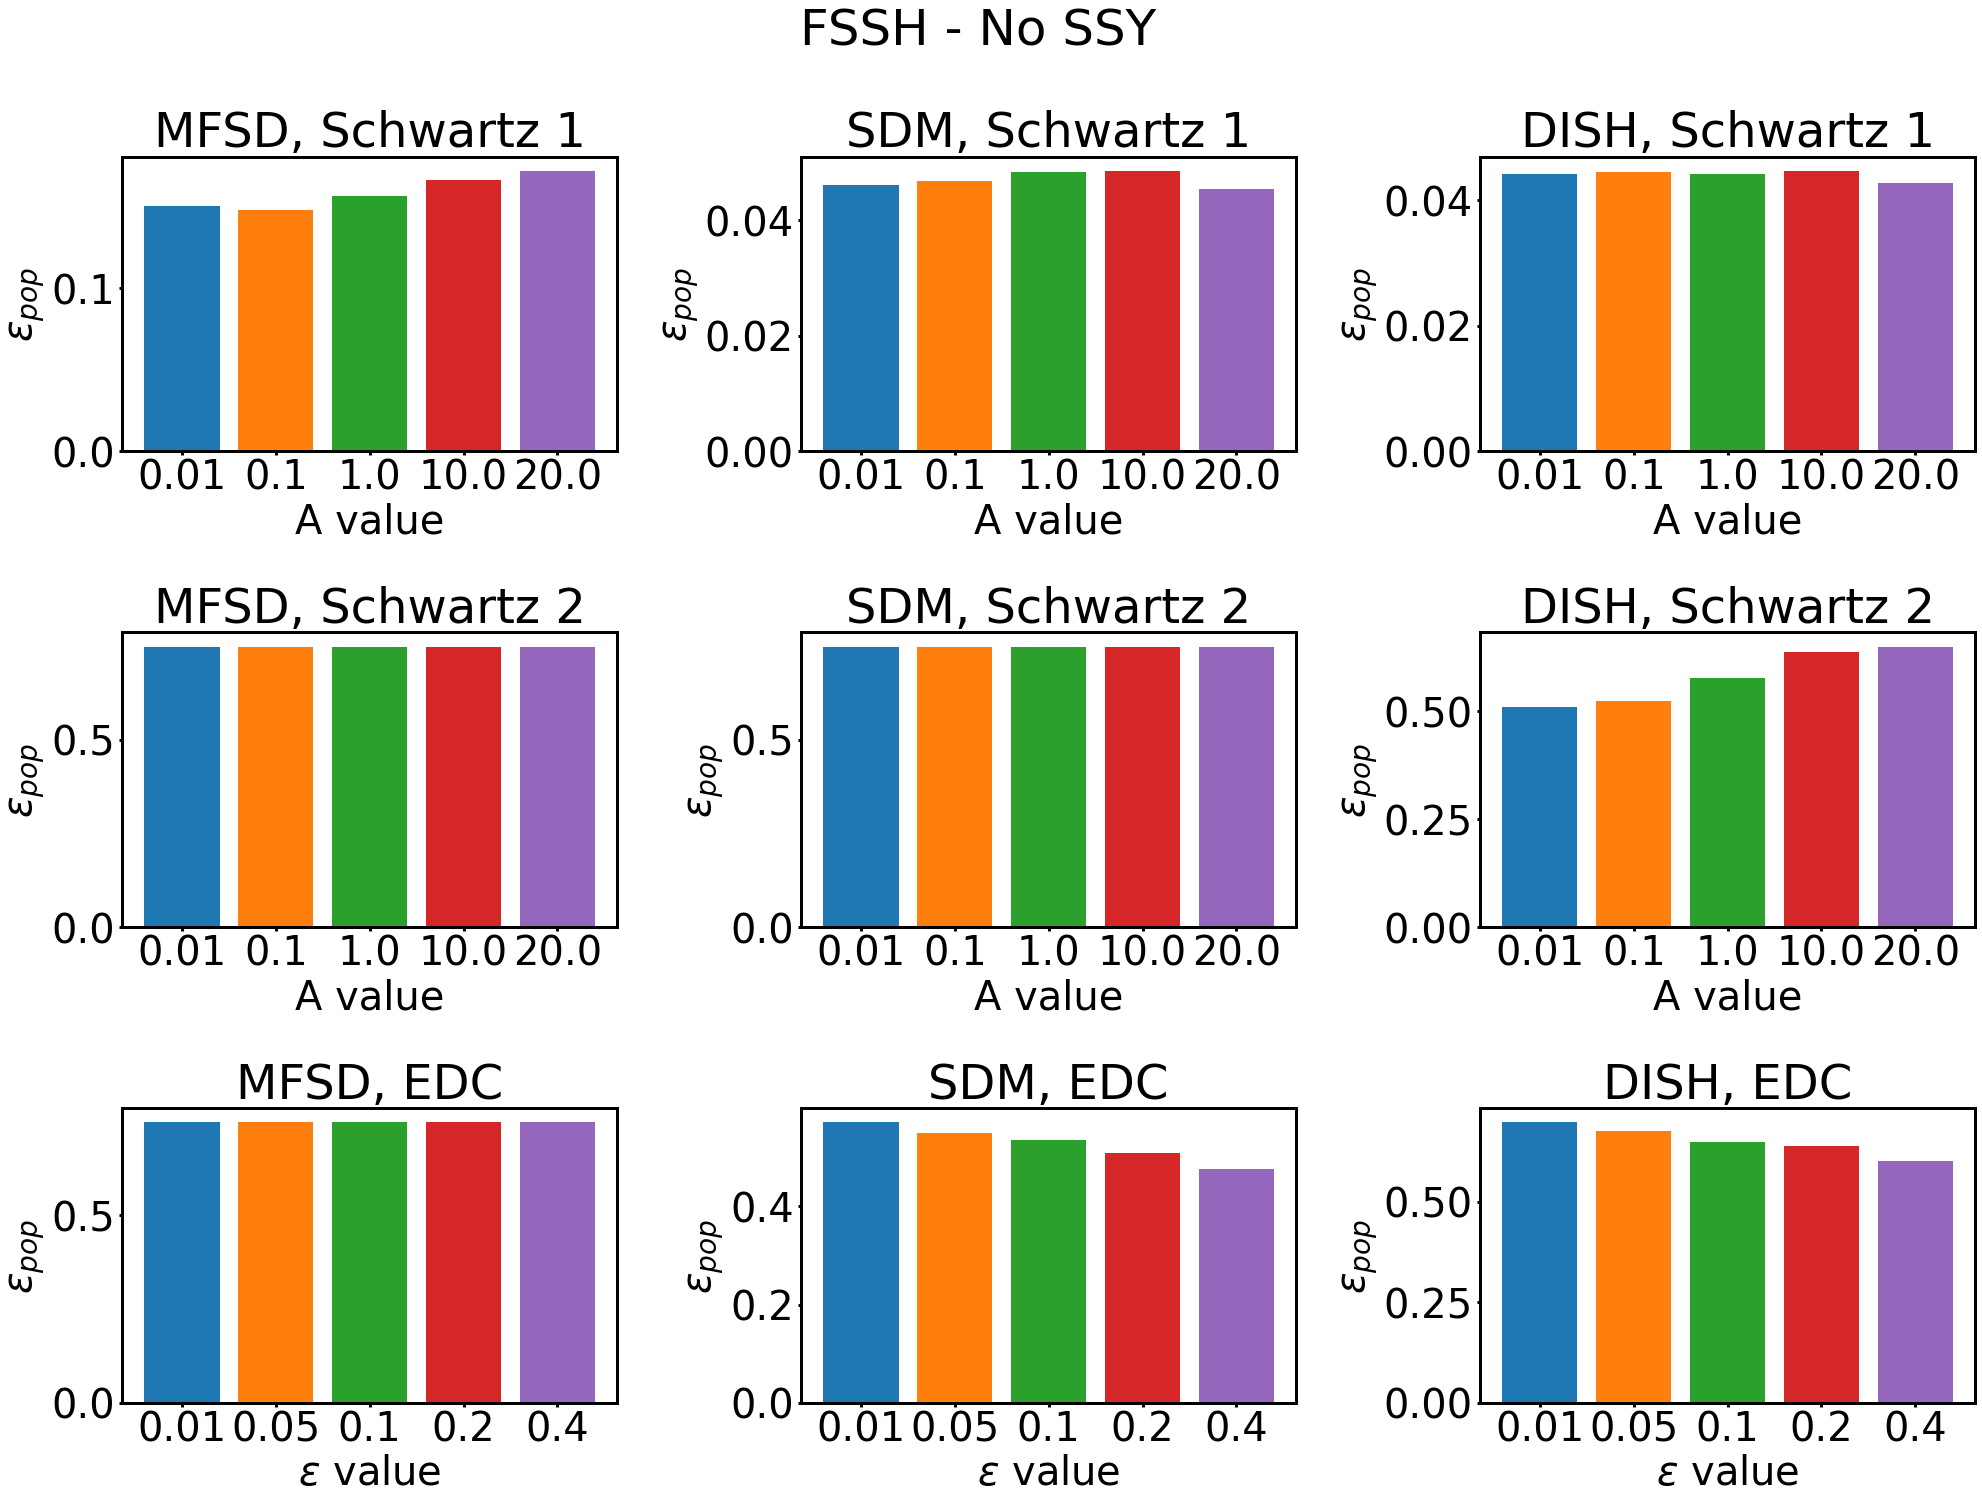

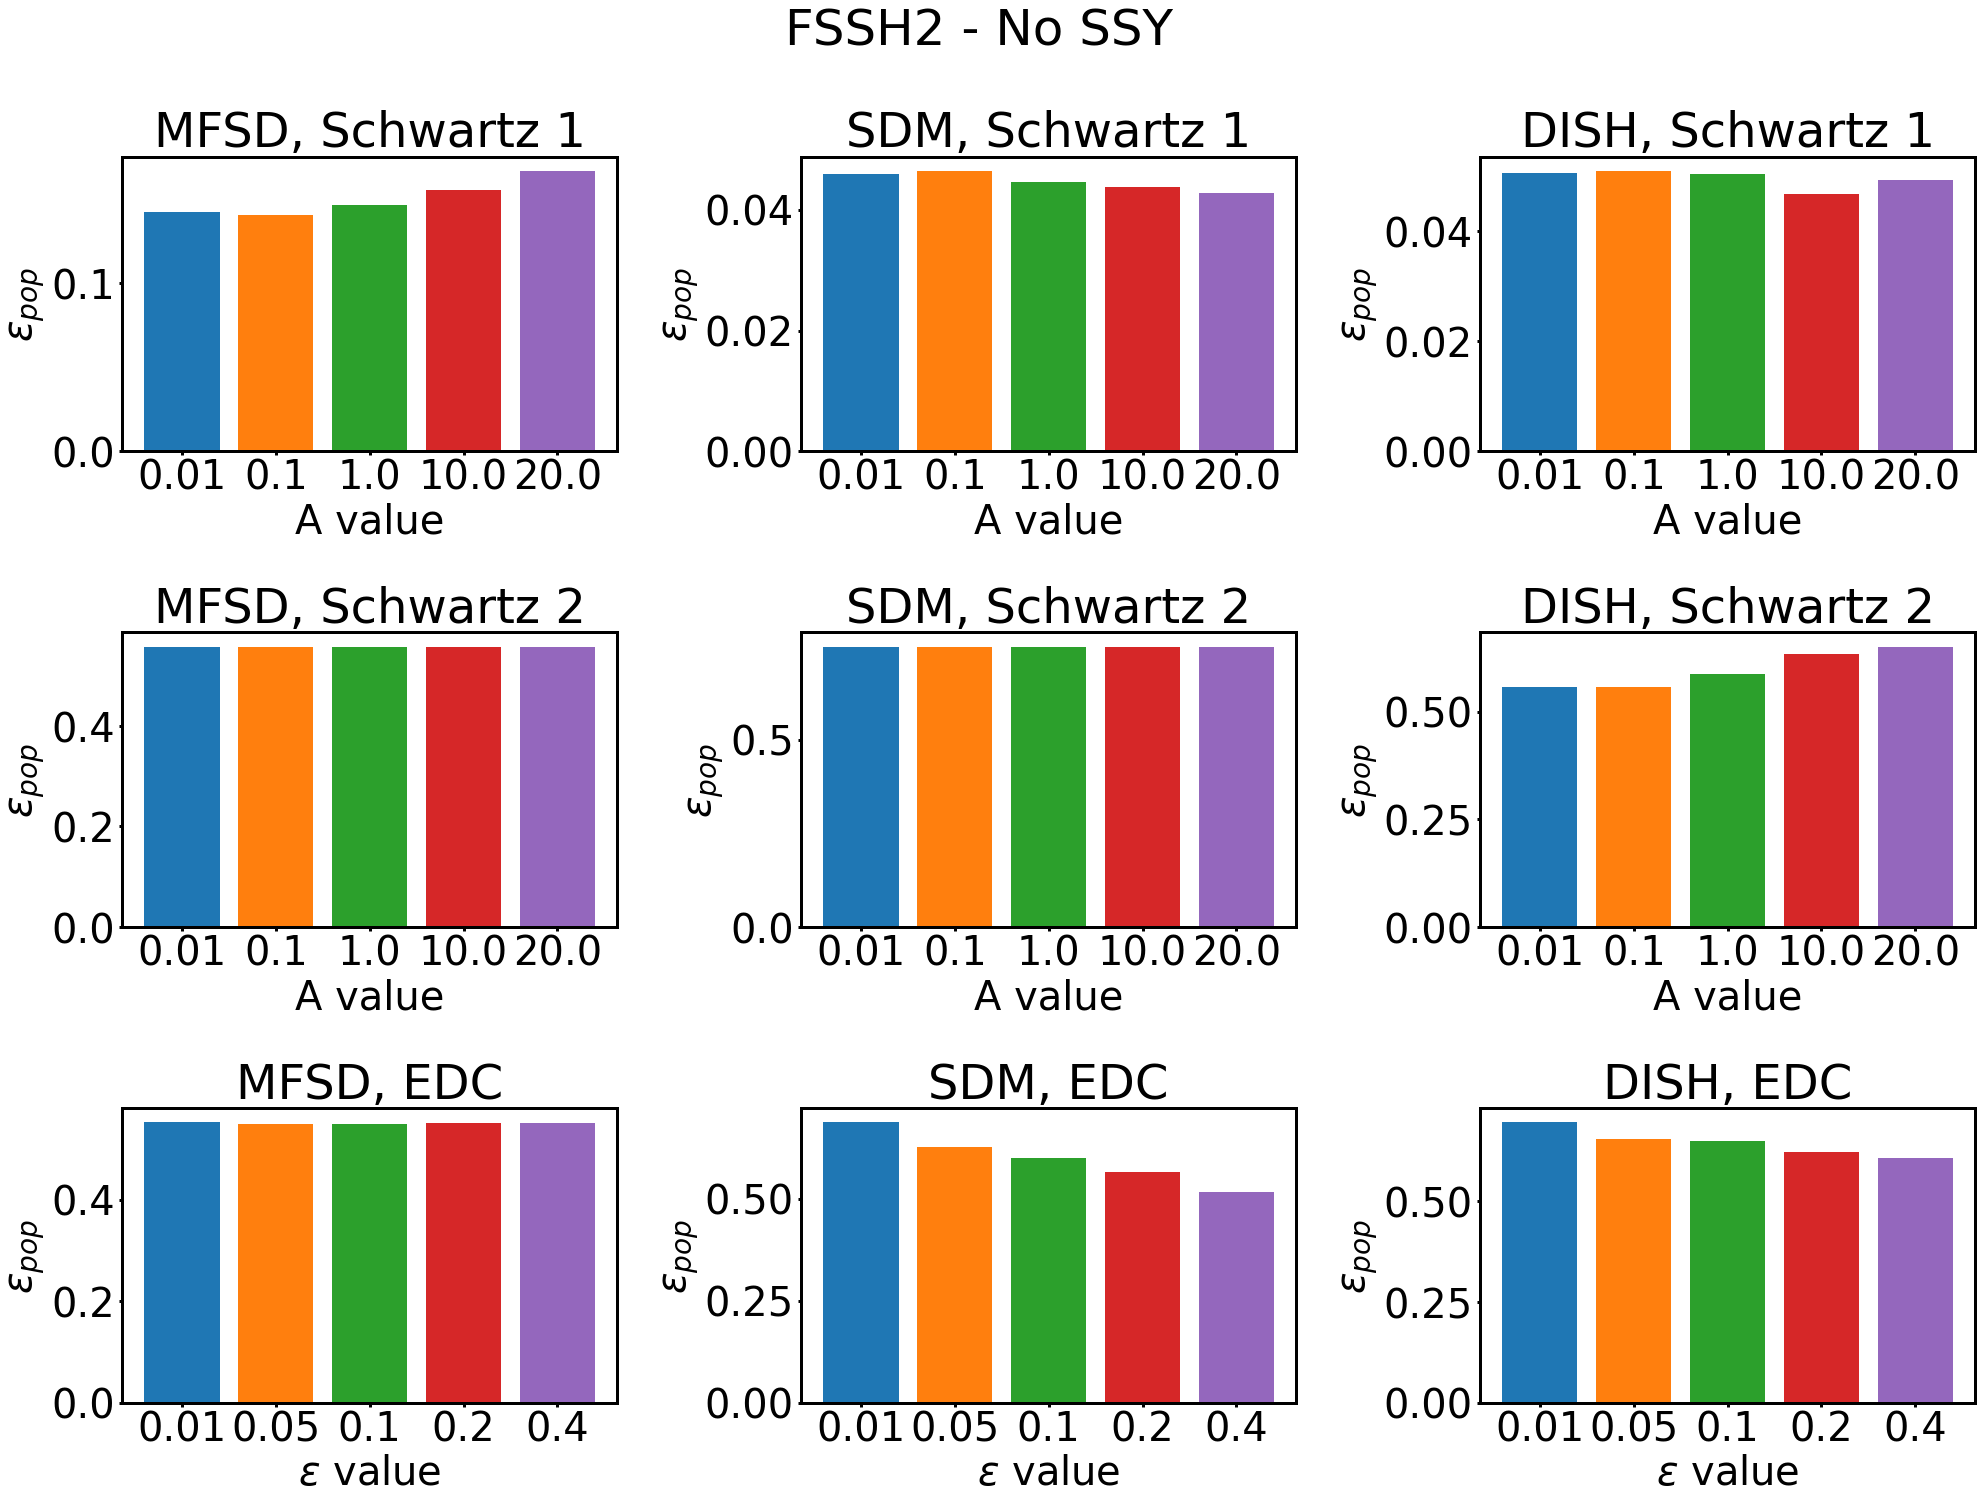

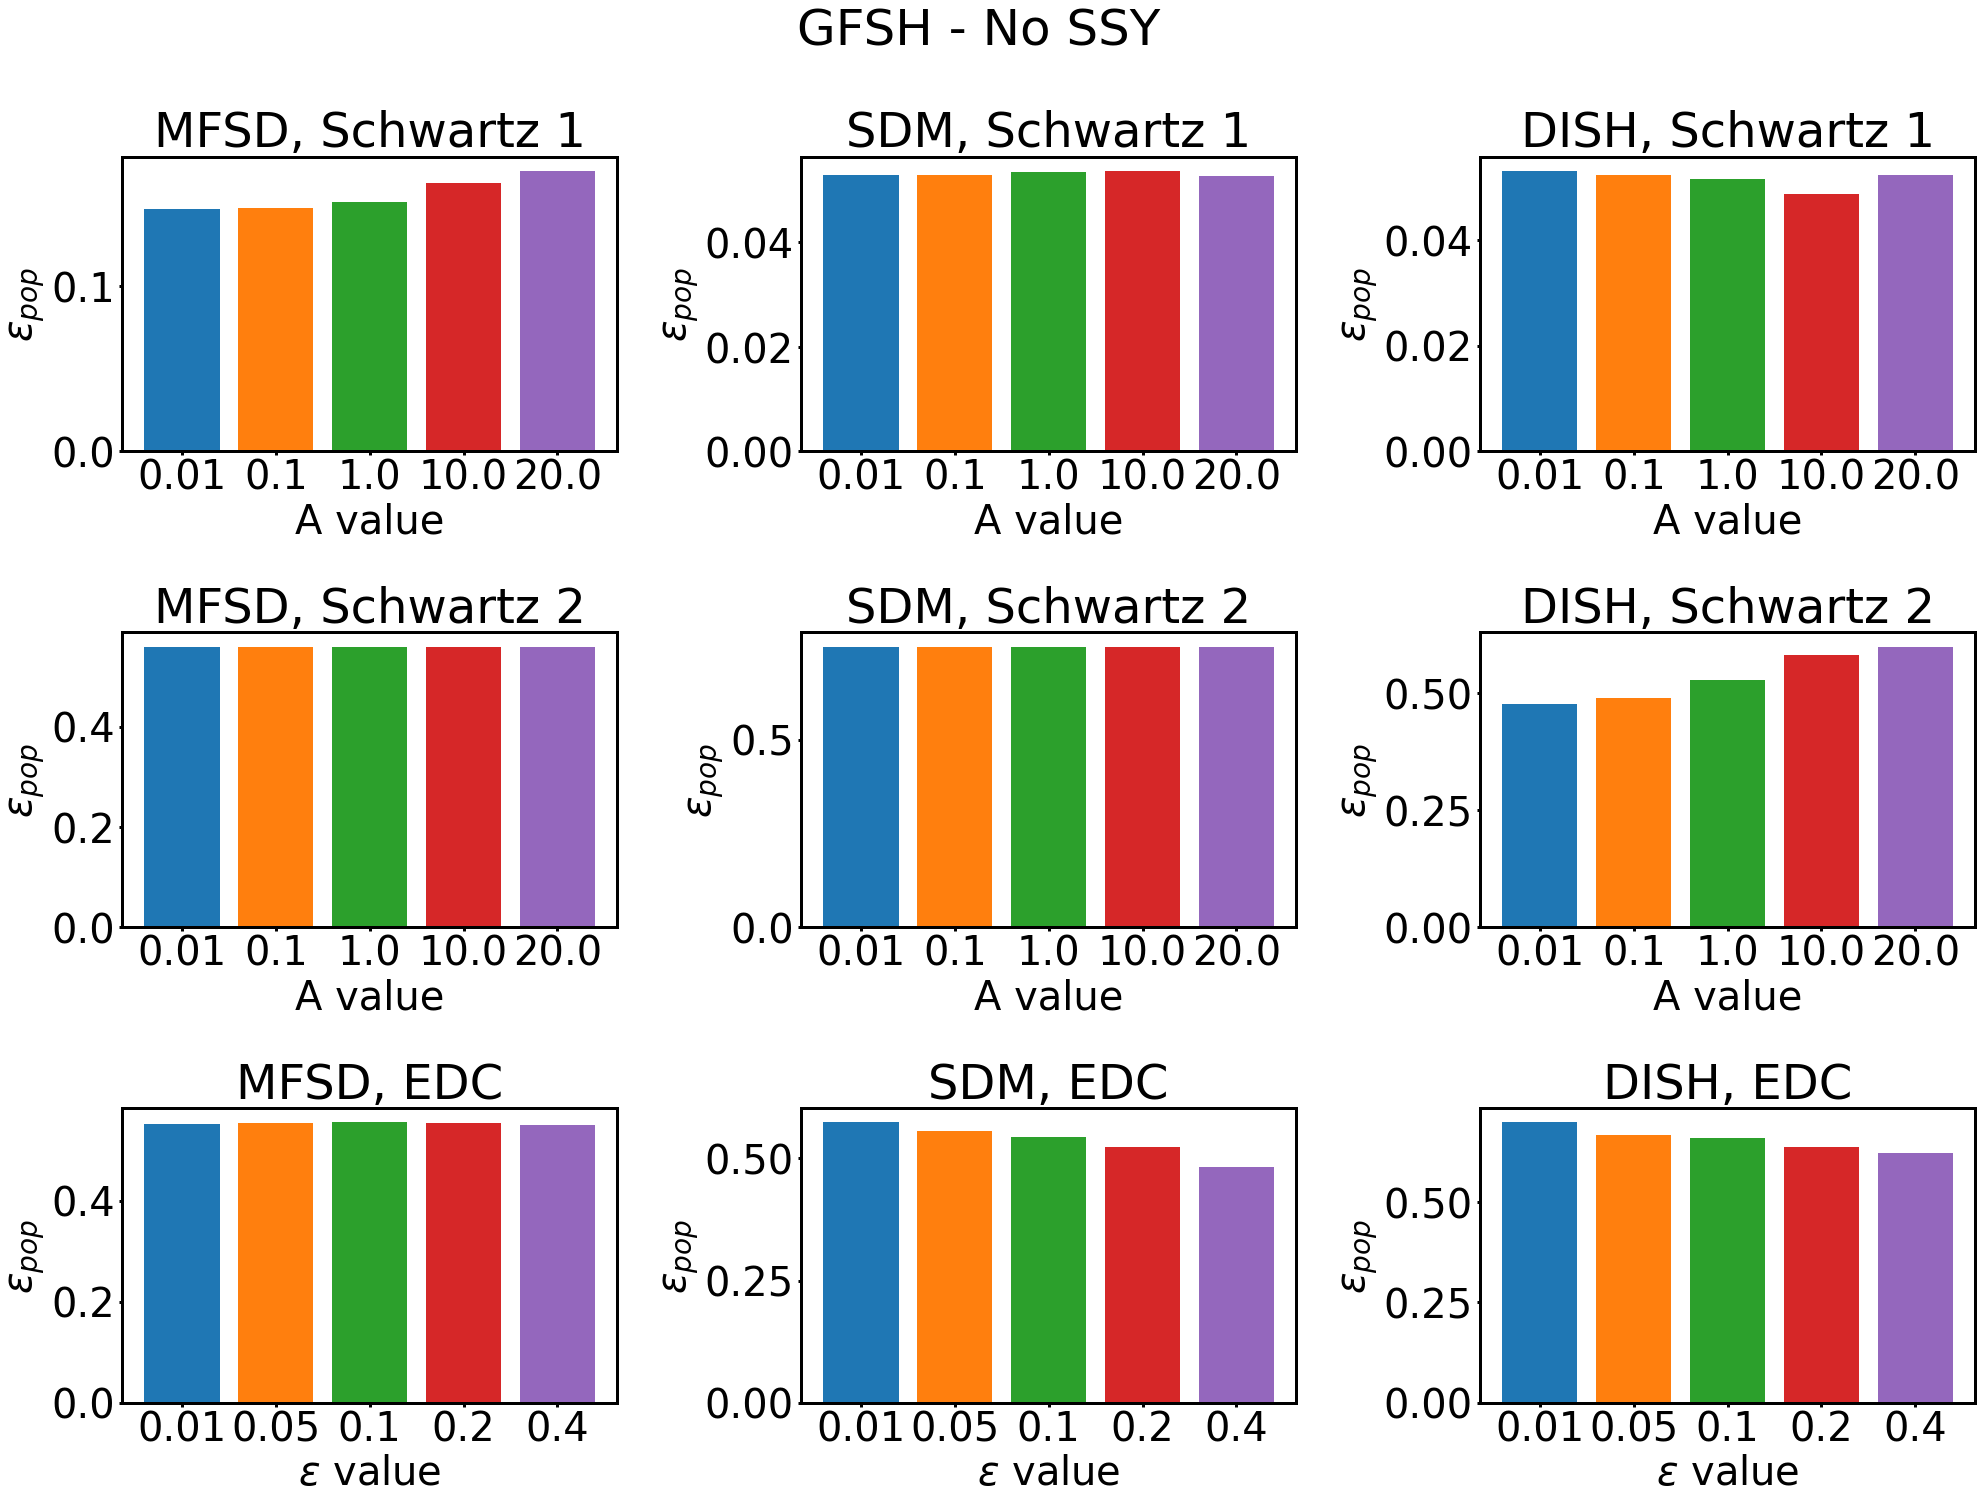

In [31]:
%matplotlib inline
from matplotlib.ticker import LogLocator
for j, method in enumerate(['FSSH','FSSH2','GFSH']):
    print(method)
    plt.figure(figsize=(3.21*3*3,2.41*3*3))
    for k, i in enumerate([0,2,4,1,3,5]):
        #print(k,i)
        plt.rcParams.update({'font.size': 40, 'axes.linewidth': 3, 'lines.linewidth': 3.0})
        #plt.figure(figsize=(3.21*3,2.41*2))
        plt.subplot(3,3,k+1)
        colors = plt.cm.tab10.colors
        ave_error = np.average(all_errors_A[j], axis=2)
        A_s = ['0.01','0.1','1.0','10.0','20.0']
        A_labels  = ['MFSD, Schwartz 1','MFSD, Schwartz 2','SDM, Schwartz 1','SDM, Schwartz 2',
                     'DISH, Schwartz 1','DISH, Schwartz 2']
        plt.bar(A_s, ave_error[:,i], color=colors)
        plt.ylabel('$\\epsilon_{pop}$')
        plt.xlabel('A value')
        #plt.yticks([])
        #plt.gca().yaxis.set_major_locator(LogLocator(base=10.0, numticks=3))
        #plt.yscale('log')
        #plt.yticks([np.min(ave_error[:,i]), np.max(ave_error[:,i])])
        #plt.gca().yaxis.set_major_locator(MaxNLocator(nbins=4))
        plt.title(A_labels[i]+'')
    for i in range(3):
        #plt.rcParams.update({'font.size': 20, 'axes.linewidth': 3, 'lines.linewidth': 3.0})
        #plt.figure(figsize=(3.21*3,2.41*2))
        plt.subplot(3,3,7+i)
        colors = plt.cm.tab10.colors
        ave_error = np.average(all_errors_eps[j], axis=2)
        eps_s = ['0.01', '0.05', '0.1', '0.2', '0.4']
        eps_labels  = ['MFSD, EDC','SDM, EDC','DISH, EDC']
        plt.bar(eps_s, ave_error[:,i], color=colors)
        plt.ylabel('$\\epsilon_{pop}$')
        plt.xlabel('$\\epsilon$ value')
        #plt.yticks([])
        #plt.gca().yaxis.set_major_locator(LogLocator(base=10.0, numticks=3))
        #plt.yscale('log')
        #plt.yticks([np.min(ave_error[:,i]), np.max(ave_error[:,i])]) 
        #plt.gca().yaxis.set_major_locator(MaxNLocator(nbins=4))
        plt.title(eps_labels[i]+'')
    plt.suptitle(f'{method} - No SSY', fontsize=50)
    plt.tight_layout()
    plt.savefig(f'{method}_A_vals_no_SSY',dpi=600)

# Now the overall error measurements (the main Figure)

FSSH
FSSH2
GFSH
['FSSH', 'FSSH-BCSH', 'FSSH-SHXF', 'FSSH-ID-A', 'FSSH-MFSD', 'FSSH-SDM', 'FSSH-DISH', 'FSSH2', 'FSSH2-BCSH', 'FSSH2-SHXF', 'FSSH2-ID-A', 'MFSD', 'FSSH2-SDM', 'FSSH2-DISH', 'GFSH', 'GFSH-BCSH', 'GFSH-SHXF', 'GFSH-ID-A', 'GFSH-MFSD', 'GFSH-SDM', 'GFSH-DISH']


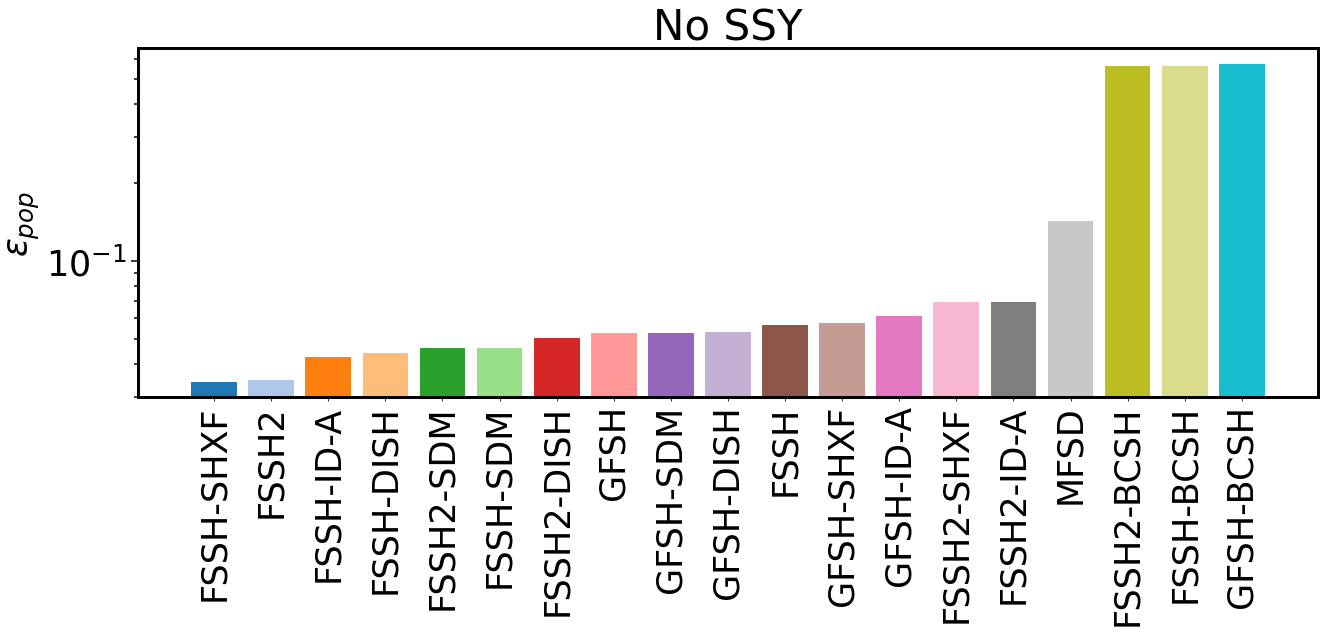

In [3]:
%matplotlib inline
plt.rcParams.update({'font.size': 35, 'axes.linewidth': 3, 'lines.linewidth': 3.0})
plt.figure(figsize=(3.21*6,2.41*4))
#colors1 = []
colors = plt.cm.tab20.colors
# for i in [2,5,6,0,4,3,1,7,8]:
#     print(i)
#     colors1.append(colors[i])
ml_mctdh = np.loadtxt('reference/ML-MCTDH_n32.dat')
main_fig_labels = []
main_fig_errors = []
for method in ['FSSH','FSSH2','GFSH']:
    print(method)
    for dec_method in ['','BCSH','SHXF','ID-A','MFSD','SDM','DISH']:
        errors = []
        for i in range(0,50):
            if dec_method=='MFSD':
                file = f'{method}/MFSD_ntraj_100_iter_{i}_A_0.01/mem_data.hdf'
            elif dec_method=='':
                file = f'{method}/{method}_ntraj_100_iter_{i}/mem_data.hdf'
            elif dec_method=='SDM':
                file = f'{method}/SDM_SCHW1_ntraj_100_iter_{i}_A_0.01/mem_data.hdf'
            elif dec_method=='DISH':
                file = f'{method}/DISH_REV23_SCHW1_ntraj_100_iter_{i}_A_0.01/mem_data.hdf'
            elif dec_method=='SHXF':
                if method=='GFSH':
                    file = f'{method}/{dec_method}_ntraj_100_iter_{i}_wp_width_0.05/mem_data.hdf'
                else:
                    file = f'{method}/{dec_method}_ntraj_100_iter_{i}_wp_width_0.1/mem_data.hdf'
            else:
                file = f'{method}/{dec_method}_ntraj_100_iter_{i}/mem_data.hdf' 
            F = h5py.File(file)
            sh_pop = np.array(F['sh_pop_adi/data'])
            F.close()
            #print(sh_pop.shape)
            #error1 = np.average(np.abs(mctdh[0:420000,1]-sh_pop[0:2100000:5,1]))
            error = np.average(np.abs(ml_mctdh[0:420000,1]-sh_pop[0:2100000:5,1]))
            errors.append(error)
        main_fig_errors.append(np.average(errors)) 
        if dec_method=='':
            main_fig_labels.append(method)
        elif dec_method=='MFSD' and method=='FSSH2':
            main_fig_labels.append(dec_method)
        else:
            main_fig_labels.append(method+'-'+dec_method)
print(main_fig_labels)
main_fig_labels = np.array(main_fig_labels)
main_fig_errors = np.array(main_fig_errors)
mask = (main_fig_labels != 'FSSH-MFSD') & (main_fig_labels != 'GFSH-MFSD')
filtered_labels = main_fig_labels[mask]
filtered_errors = main_fig_errors[mask]
sorted_indices = np.argsort(filtered_errors)
sorted_labels = filtered_labels[sorted_indices]
sorted_errors = filtered_errors[sorted_indices]
plt.bar(sorted_labels, sorted_errors, color=colors)
# indices_1 = np.argsort(main_fig_errors)
# plt.bar(main_fig_labels[indices_1], main_fig_errors[indices_1], color=colors)
plt.ylabel('$\\epsilon_{pop}$')
plt.tick_params(axis='y', width=3)
plt.tick_params(axis='y', which='minor', width=1.5, length=4)
plt.tick_params(axis='y', which='major', width=1.5, length=7)
plt.yscale('log')
plt.xticks(rotation=90)  # or 90 for vertical
plt.title('No SSY')
plt.tight_layout()
plt.savefig(f'main_fig_error_no_ssy.jpg',dpi=600)

In [10]:
print(main_fig_labels)

['FSSH' 'FSSH-BCSH' 'FSSH-SHXF' 'FSSH-ID-A' 'FSSH-MFSD' 'FSSH-SDM'
 'FSSH-DISH' 'FSSH2' 'FSSH2-BCSH' 'FSSH2-SHXF' 'FSSH2-ID-A' 'MFSD'
 'FSSH2-SDM' 'FSSH2-DISH' 'GFSH' 'GFSH-BCSH' 'GFSH-SHXF' 'GFSH-ID-A'
 'GFSH-MFSD' 'GFSH-SDM' 'GFSH-DISH']


FSSH
FSSH2
GFSH


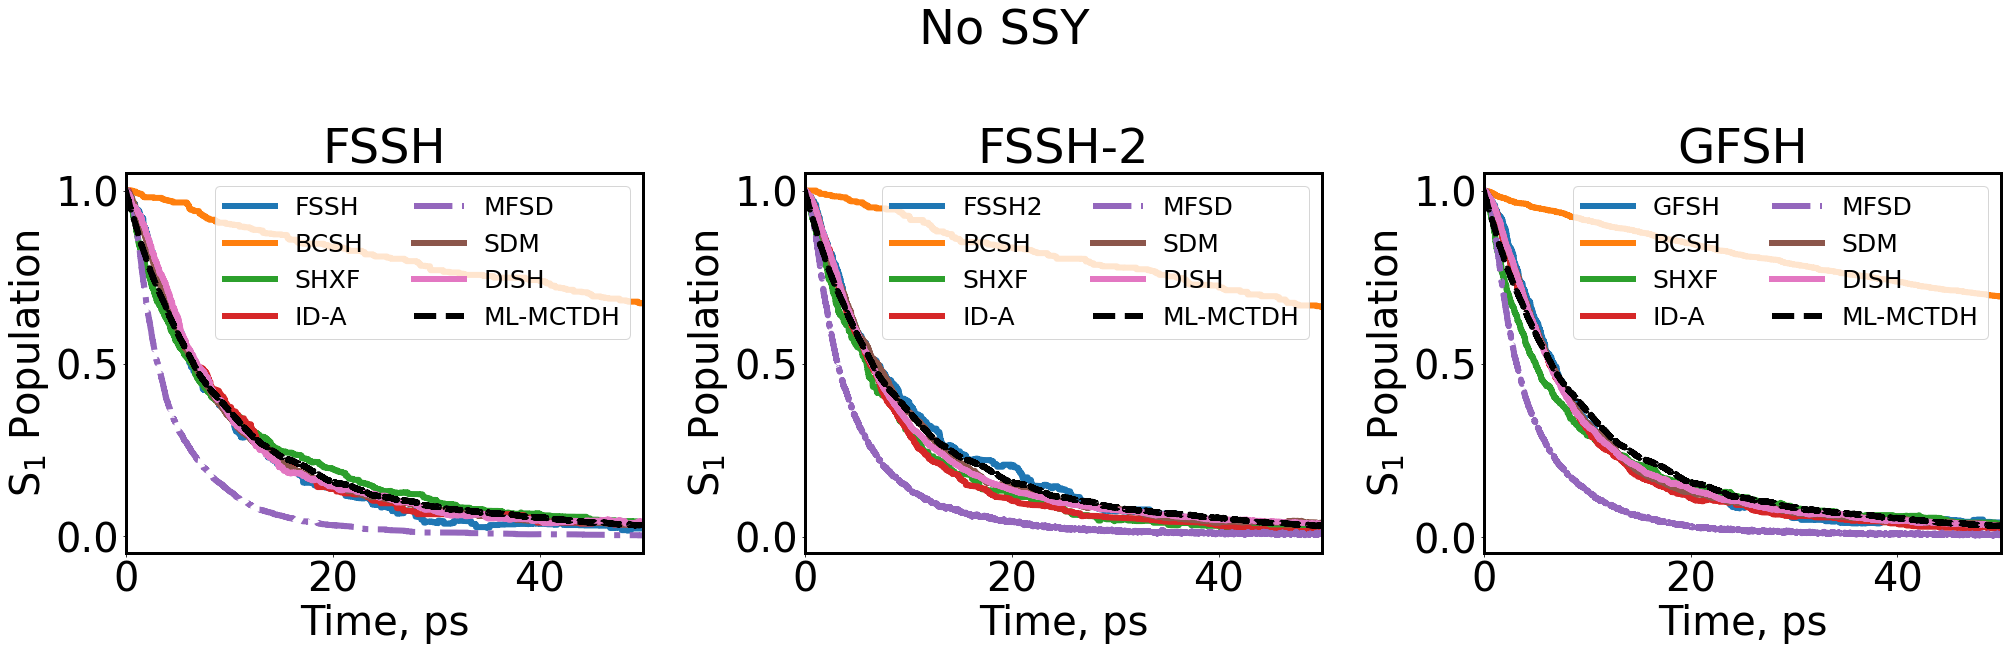

In [4]:
%matplotlib inline
plt.rcParams.update({'font.size': 40, 'axes.linewidth': 3, 'lines.linewidth': 6.0})
plt.figure(figsize=(3.21*9,2.41*4))
#colors1 = []
colors = plt.cm.tab20.colors
F = h5py.File('FSSH/time.hdf')
time_vec = F['time/data'][:]*units.au2fs/1000
F.close()
# for i in [2,5,6,0,4,3,1,7,8]:
#     print(i)
#     colors1.append(colors[i])
main_fig_labels = []
main_fig_errors = []
for c, method in enumerate(['FSSH','FSSH2','GFSH']):
    print(method)
    plt.subplot(1,3,c+1) 
    for dec_method in ['','BCSH','SHXF','ID-A','MFSD','SDM','DISH']:
        sh_pops = []
        for i in range(0,50):
            if dec_method=='':
                file = f'{method}/{method}_ntraj_100_iter_{i}/mem_data.hdf'
            elif dec_method=='MFSD':
                file = f'{method}/MFSD_ntraj_100_iter_{i}_A_0.01/mem_data.hdf'
            elif dec_method=='SDM':
                file = f'{method}/SDM_SCHW1_ntraj_100_iter_{i}_A_0.01/mem_data.hdf'
            elif dec_method=='DISH':
                file = f'{method}/DISH_REV23_SCHW1_ntraj_100_iter_{i}_A_0.01/mem_data.hdf'
            elif dec_method=='SHXF':
                if method=='GFSH':
                    file = f'{method}/{dec_method}_ntraj_100_iter_{i}_wp_width_0.05/mem_data.hdf'
                else:
                    file = f'{method}/{dec_method}_ntraj_100_iter_{i}_wp_width_0.1/mem_data.hdf'
            else:
                file = f'{method}/{dec_method}_ntraj_100_iter_{i}/mem_data.hdf' 
            F = h5py.File(file)
            sh_pop = np.array(F['sh_pop_adi/data'])
            sh_pops.append(sh_pop)
            F.close()
            #print(sh_pop.shape)
            #error1 = np.average(np.abs(mctdh[0:420000,1]-sh_pop[0:2100000:5,1]))
            #error = np.average(np.abs(ml_mctdh[0:420000,1]-sh_pop[0:2100000:5,1]))
            #errors.append(error)
        if dec_method=='':
            plt.plot(time_vec, np.average(sh_pops, axis=0)[:,1], label=method)
        elif dec_method=='MFSD':
            plt.plot(time_vec, np.average(sh_pops, axis=0)[:,1], label='MFSD', ls='-.')
        else:
            plt.plot(time_vec, np.average(sh_pops, axis=0)[:,1], label=dec_method)
        
    ml_mctdh = np.loadtxt('reference/ML-MCTDH_n32.dat')
    plt.plot(ml_mctdh[:,0]/1000, ml_mctdh[:,1], label='ML-MCTDH', ls='dashed', color='black')
    plt.xlim(0,50)
    #if c==0:
    plt.legend(fontsize=25, ncol=2, loc='upper right')
    plt.ylabel('S$_1$ Population')
    plt.xlabel('Time, ps')
    if method=='FSSH2':
        plt.title(f'FSSH-2')
    else:
        plt.title(method) 
plt.suptitle('No SSY')
plt.tight_layout()
plt.savefig(f'main_fig_dyn_no_ssy.jpg',dpi=600)

# SHXF results with different wavepacket width

FSSH
FSSH2
GFSH


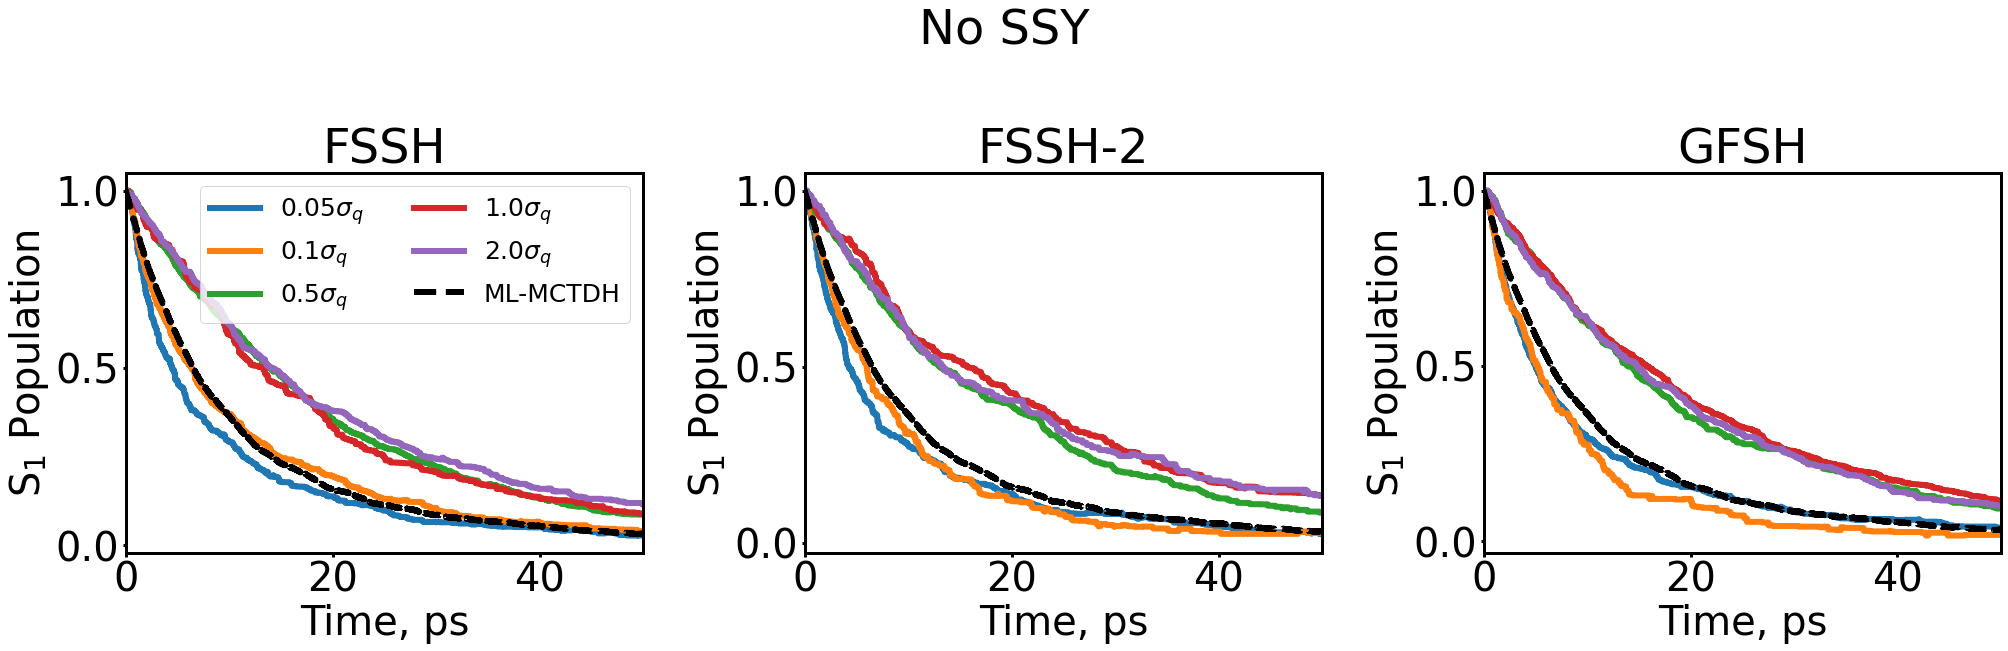

In [16]:
%matplotlib inline
plt.rcParams.update({'font.size': 40, 'axes.linewidth': 3, 'lines.linewidth': 6.0})
plt.figure(figsize=(3.21*9,2.41*4))
#colors1 = []
colors = plt.cm.tab20.colors
F = h5py.File('FSSH/time.hdf')
time_vec = F['time/data'][:]*units.au2fs/1000
F.close()
# for i in [2,5,6,0,4,3,1,7,8]:
#     print(i)
#     colors1.append(colors[i])
main_fig_labels = []
main_fig_errors = []
for c, method in enumerate(['FSSH','FSSH2','GFSH']):
    print(method)
    plt.subplot(1,3,c+1) 
    for sigma_val in [0.05, 0.1, 0.5, 1.0, 2.0]:
        sh_pops = []
        for i in range(0,50):
            if sigma_val!=1.0:
                file = f'{method}/SHXF_ntraj_100_iter_{i}_wp_width_{sigma_val}/mem_data.hdf'
            else:
                file = f'{method}/SHXF_ntraj_100_iter_{i}/mem_data.hdf'
            F = h5py.File(file)
            sh_pop = np.array(F['sh_pop_adi/data'])
            sh_pops.append(sh_pop)
            F.close()
            #print(sh_pop.shape)
            #error1 = np.average(np.abs(mctdh[0:420000,1]-sh_pop[0:2100000:5,1]))
            #error = np.average(np.abs(ml_mctdh[0:420000,1]-sh_pop[0:2100000:5,1]))
            #errors.append(error)
        plt.plot(time_vec, np.average(sh_pops, axis=0)[:,1], label=f'{sigma_val}$\\sigma_q$')
        
    ml_mctdh = np.loadtxt('reference/ML-MCTDH_n32.dat')
    plt.plot(ml_mctdh[:,0]/1000, ml_mctdh[:,1], label='ML-MCTDH', ls='dashed', color='black')
    plt.xlim(0,50)
    if c==0:
        plt.legend(fontsize=25, ncol=2, loc='upper right')
    plt.ylabel('S$_1$ Population')
    plt.xlabel('Time, ps')
    if method=='FSSH2':
        plt.title('FSSH-2')
    else:    
        plt.title(method)
plt.suptitle('No SSY')
plt.tight_layout()
plt.savefig(f'shxf_dyn_no_ssy.jpg',dpi=600)